In [1]:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from keras.layers.pooling import *
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import PIL

2022-11-29 11:49:33.849784: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# An arbitary model with a pooling filter of 2x2 with a stride value of 2

In [2]:
model_valid = Sequential([
    Dense(16, input_shape=(20,20,3), activation='relu'),
    Conv2D(32, kernel_size=(3,3), activation='relu', padding='same'),   # Padding same means even addition of 0's in all directions, with a stride of 1 input size = output size
    MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'),   # Valid padding means no padding is usedwhich is common on pooling layers
    Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'),
    Flatten(),
    Dense(2, activation='softmax')
])
model_valid.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20, 20, 16)        64        
                                                                 
 conv2d (Conv2D)             (None, 20, 20, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 flatten (Flatten)           (None, 6400)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 12802     
                                                        

2022-11-29 11:49:49.349097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### An example of a CNN

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


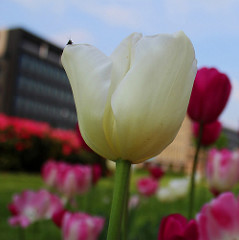

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[1]))

In [6]:
batch_size = 32
img_height = 180
img_width = 180

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


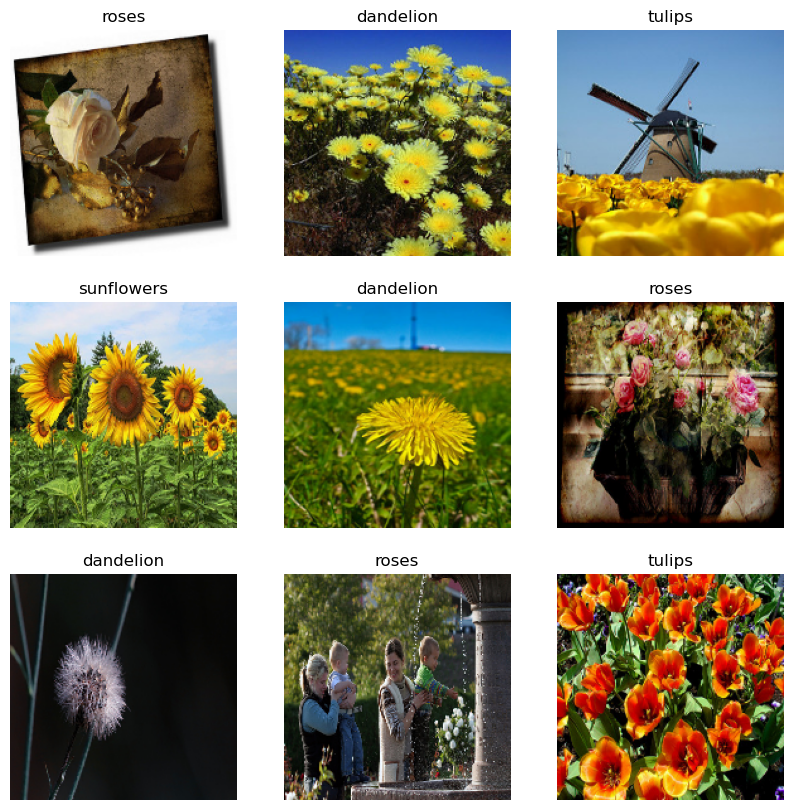

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Images are 180x180 with 3 channels (RGB) with a batch size of 32
Label batch size matches the image batch size, 1 label per image

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


These are steps to give better performance while fetching the data
Cache - Keeps images on the disk after loading during the first epoch - Prevents the dataset becoming a bottleneck during model training
Prefetch - Overlaps data preprocessing and model excecution while training

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

We have large RGB channel ranges (0-255)
Ideally we want smaller values for use in a CNN so we can standardize these values

In [13]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.045294102 0.9959968


In [14]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),  # 16 output filters, 3x3 kernel size
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(), # Flatten our feature maps into a 1D vector
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes) # This is where our classification happens
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)       

In [16]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 23s 247ms/step - loss: 1.2923 - accuracy: 0.4520 - val_loss: 1.0668 - val_accuracy: 0.5790
Epoch 2/10
92/92 [==============================] - 22s 240ms/step - loss: 1.0142 - accuracy: 0.5991 - val_loss: 0.9886 - val_accuracy: 0.5845
Epoch 3/10
92/92 [==============================] - 22s 238ms/step - loss: 0.8404 - accuracy: 0.6863 - val_loss: 0.8928 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 22s 237ms/step - loss: 0.6517 - accuracy: 0.7575 - val_loss: 0.9921 - val_accuracy: 0.6390
Epoch 5/10
92/92 [==============================] - 27s 292ms/step - loss: 0.4628 - accuracy: 0.8294 - val_loss: 1.0331 - val_accuracy: 0.6594
Epoch 6/10
92/92 [==============================] - 22s 244ms/step - loss: 0.2978 - accuracy: 0.8999 - val_loss: 1.1215 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 23s 251ms/step - loss: 0.1530 - accuracy: 0.9550 - val_loss: 1.4673 - val_accuracy: 0.6362

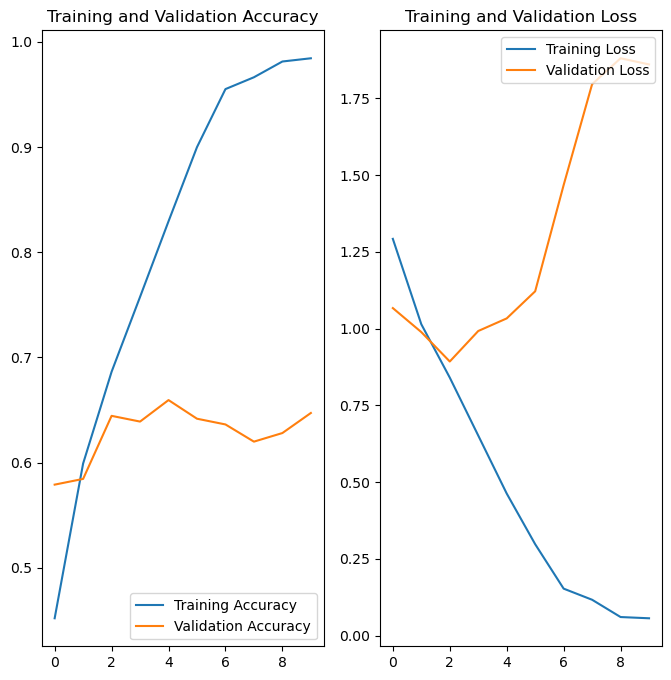

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Currently our model is overfitting in order fix this we can use data augmentation and dropout

Data augmentation increases the size of the training data by applying random augmentations to images

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

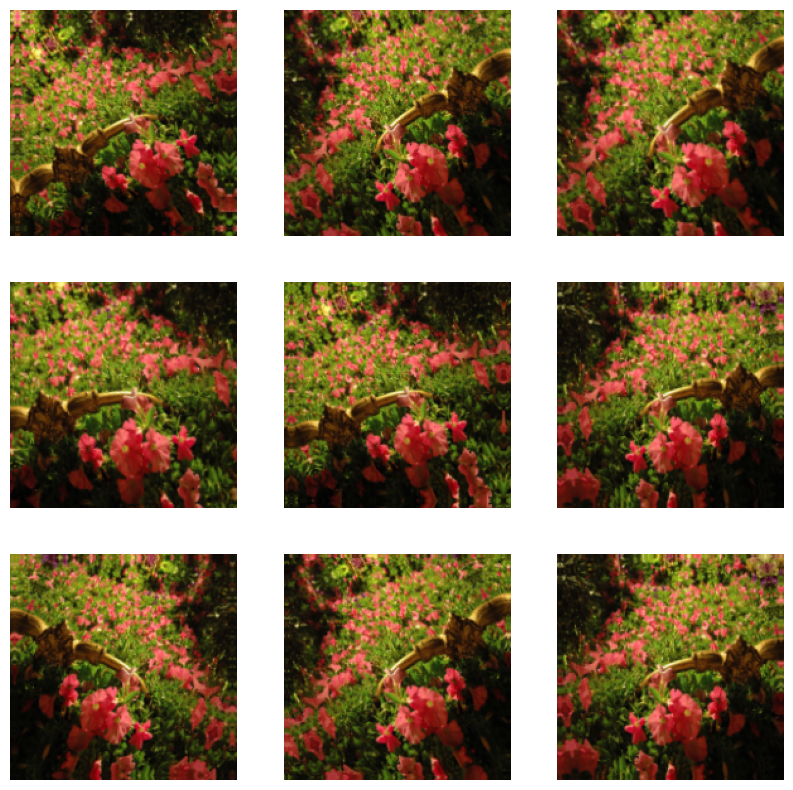

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Dropout randomly removes a number of outputs from a layer during training which helps for regularisation

In [20]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 28s 285ms/step - loss: 1.2929 - accuracy: 0.4564 - val_loss: 1.1692 - val_accuracy: 0.5163
Epoch 2/15
92/92 [==============================] - 27s 289ms/step - loss: 1.0308 - accuracy: 0.5760 - val_loss: 1.0427 - val_accuracy: 0.5954
Epoch 3/15
92/92 [==============================] - 26s 282ms/step - loss: 0.9308 - accuracy: 0.6376 - val_loss: 1.0046 - val_accuracy: 0.6240
Epoch 4/15
92/92 [==============================] - 26s 283ms/step - loss: 0.8488 - accuracy: 0.6744 - val_loss: 0.8976 - val_accuracy: 0.6444
Epoch 5/15
92/92 [==============================] - 25s 276ms/step - loss: 0.7674 - accuracy: 0.7098 - val_loss: 0.8680 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 25s 273ms/step - loss: 0.7559 - accuracy: 0.7142 - val_loss: 0.8956 - val_accuracy: 0.6580
Epoch 7/15
92/92 [==============================] - 25s 269ms/step - loss: 0.7144 - accuracy: 0.7306 - val_loss: 0.8394 - val_accuracy: 0.6907

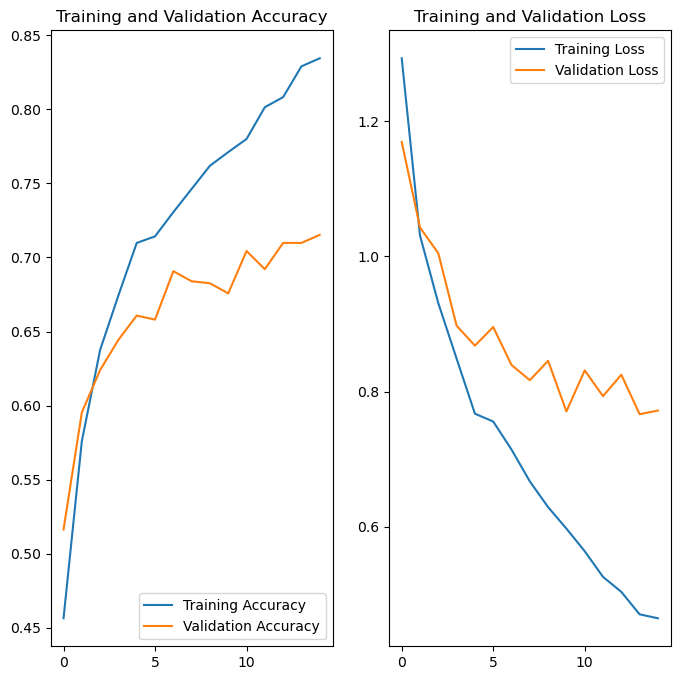

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 43ms/step
This image most likely belongs to sunflowers with a 95.46 percent confidence.


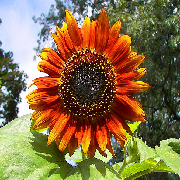

In [25]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

img

Can we optimize our pooling layer to decrease overfitting?

In [28]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(strides=2), # Changing stride from default of 1 to 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(strides=2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(strides=2),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [29]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 27s 278ms/step - loss: 1.3193 - accuracy: 0.4193 - val_loss: 1.1421 - val_accuracy: 0.5027
Epoch 2/15
92/92 [==============================] - 26s 279ms/step - loss: 1.0580 - accuracy: 0.5678 - val_loss: 1.0440 - val_accuracy: 0.5804
Epoch 3/15
92/92 [==============================] - 27s 292ms/step - loss: 0.9670 - accuracy: 0.6236 - val_loss: 0.9595 - val_accuracy: 0.6144
Epoch 4/15
92/92 [==============================] - 27s 295ms/step - loss: 0.8635 - accuracy: 0.6696 - val_loss: 0.8851 - val_accuracy: 0.6349
Epoch 5/15
92/92 [==============================] - 25s 268ms/step - loss: 0.8170 - accuracy: 0.6836 - val_loss: 0.8344 - val_accuracy: 0.6621
Epoch 6/15
92/92 [==============================] - 25s 273ms/step - loss: 0.7591 - accuracy: 0.7071 - val_loss: 0.8336 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 25s 274ms/step - loss: 0.7171 - accuracy: 0.7197 - val_loss: 0.7385 - val_accuracy: 0.7084

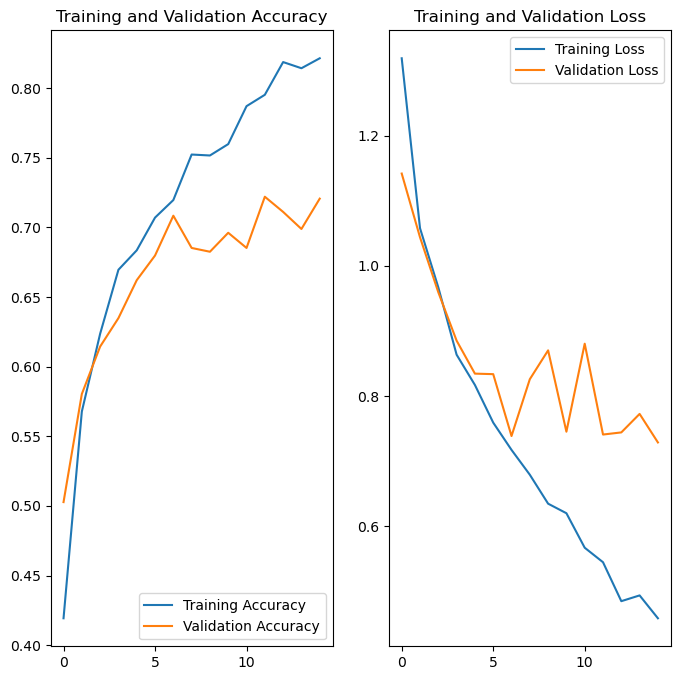

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()